# Object Detection Model Enhancement Project

This notebook demonstrates the process of enhancing an object detection model using the Oxford-IIIT Pet Dataset. The steps include dataset loading and preparation, model architecture setup, training, evaluation, fine-tuning, and deployment with custom image testing.

## Initial Setup

### Import Necessary Libraries

First, we import the essential libraries required for data manipulation, model building, and visualization.


In [25]:
# Import necessary libraries
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import numpy as np


In this code block, we import the necessary libraries for our project. We use TensorFlow and TensorFlow Datasets for building and training the model, and Matplotlib and NumPy for visualization and numerical operations.


### Helper Function to Visualize Data

We define a helper function to visualize the dataset samples with their corresponding class names.


In [55]:
# Helper function to visualize data
def show_samples(dataset, num_samples=5):
    plt.figure(figsize=(10, 10))
    for i, sample in enumerate(dataset.take(num_samples)):
        image = sample['image']
        label = sample['label']
        label_name = class_names[label]
        plt.subplot(1, num_samples, i+1)
        plt.imshow(image)
        plt.title(label_name) # Changed line. Convert the label to a string using str()
        plt.axis('off')
    plt.show()

This function, `show_samples`, takes a dataset and a list of class names as inputs. It displays a specified number of sample images from the dataset along with their class names. The function resizes the images for display and converts the numerical labels to their corresponding class names.


## Dataset Selection and Preparation

### Load the Oxford-IIIT Pet Dataset

We load the Oxford-IIIT Pet Dataset and extract class names for further use in visualization and labeling.


In [52]:
# Load the Oxford-IIIT Pet Dataset
dataset, info = tfds.load('oxford_iiit_pet', with_info=True, as_supervised=False)
class_names = info.features['label'].names
train_dataset, test_dataset = dataset['train'], dataset['test']

### Show Sample Images from the Dataset

Using the helper function, we display a few sample images from the dataset along with their class names to understand the dataset's structure.


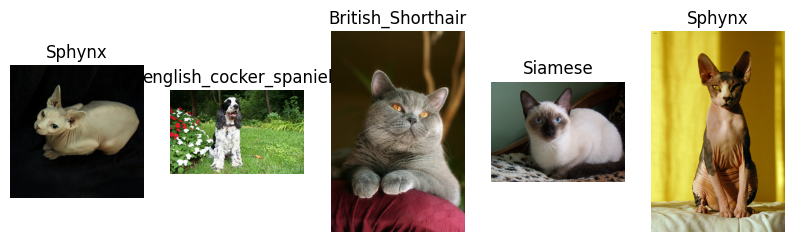

In [56]:
# Show sample images from the dataset
show_samples(train_dataset)


Here, we call the `show_samples` function to display a few sample images from the training set of the dataset. This helps us visualize the dataset and understand the variety of images and labels it contains.


### Data Preprocessing and Augmentation

Define a function to preprocess and augment the images. This includes resizing, normalizing, and applying random transformations to the images.


In [28]:
# Data preprocessing and augmentation
def preprocess_and_augment(data):
    image = tf.image.resize(data['image'], (128, 128))
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, 0.1)
    image = image / 255.0  # Normalize to [0, 1] range
    return image, data['label'] # Changed line. Removed 'objects' from the key

### Prepare Training and Testing Datasets

Apply the preprocessing and augmentation function to the training and testing datasets and prepare them for model training.


In [29]:
# Prepare training and testing datasets
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.map(preprocess_and_augment, num_parallel_calls=AUTOTUNE)
train_dataset = train_dataset.shuffle(1024).batch(32).prefetch(buffer_size=AUTOTUNE)

test_dataset = test_dataset.map(preprocess_and_augment, num_parallel_calls=AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(buffer_size=AUTOTUNE)


In this code block, we prepare the training and testing datasets. We apply the preprocessing and augmentation function to both datasets, shuffle the training dataset, batch the data into groups of 32, and prefetch the data to improve the input pipeline performance.


## Model Architecture

### Define the Base Model and Architecture

Set up the base model using MobileNetV2 and add custom layers for classification. Compile the model with appropriate loss and metrics.


In [30]:
# Model architecture
base_model = tf.keras.applications.MobileNetV2(input_shape=(128, 128, 3),
                                               include_top=False,
                                               weights='imagenet')

base_model.trainable = False

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(1024, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(37, activation='softmax')
])

model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


9406464/9406464 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_128 (Func  (None, 4, 4, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 1024)              1311744   
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 37)                37925     
                                                           

This code block sets up the base model for our object detection task. We use the MobileNetV2 model pre-trained on ImageNet, excluding the top classification layer. We add a global average pooling layer, a dense layer with ReLU activation, a dropout layer for regularization, and a final dense layer for classification. The model is compiled with the Adam optimizer, sparse categorical cross-entropy loss, and accuracy as the metric.


## Training

### Train the Model

Train the model using the training dataset and validate it on the testing dataset for a specified number of epochs.


In [31]:
# Train the model
history = model.fit(train_dataset,
                    validation_data=test_dataset,
                    epochs=10)


Epoch 1/10
115/115 [==============================] - 104s 831ms/step - loss: 1.1051 - accuracy: 0.6815 - val_loss: 0.7854 - val_accuracy: 0.7626
Epoch 2/10
115/115 [==============================] - 133s 1s/step - loss: 0.3439 - accuracy: 0.8864 - val_loss: 0.6683 - val_accuracy: 0.7999
Epoch 3/10
115/115 [==============================] - 91s 762ms/step - loss: 0.1833 - accuracy: 0.9421 - val_loss: 0.7834 - val_accuracy: 0.7855
Epoch 4/10
115/115 [==============================] - 91s 773ms/step - loss: 0.1166 - accuracy: 0.9628 - val_loss: 0.7618 - val_accuracy: 0.7964
Epoch 5/10
115/115 [==============================] - 132s 1s/step - loss: 0.0668 - accuracy: 0.9818 - val_loss: 0.8009 - val_accuracy: 0.7910
Epoch 6/10
115/115 [==============================] - 127s 1s/step - loss: 0.0515 - accuracy: 0.9842 - val_loss: 0.8689 - val_accuracy: 0.7844
Epoch 7/10
115/115 [==============================] - 127s 1s/step - loss: 0.0398 - accuracy: 0.9889 - val_loss: 0.8775 - val_accuracy:

## Evaluation

### Evaluate the Model

Evaluate the model's performance on the testing dataset and display the accuracy.


In [32]:
# Evaluate the model
loss, accuracy = model.evaluate(test_dataset)
print(f'Test accuracy: {accuracy:.2f}')

115/115 [==============================] - 50s 425ms/step - loss: 0.9875 - accuracy: 0.7858
Test accuracy: 0.79


After training, we evaluate the model's performance on the testing dataset to see how well it generalizes to new data. We print the test accuracy to measure the model's performance.


### Plot Training History

Visualize the training and validation loss and accuracy over epochs to understand the model's performance.


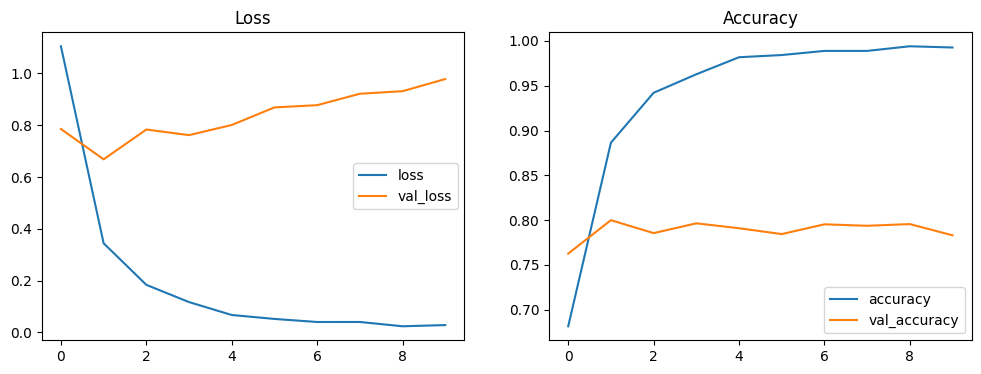

In [33]:
# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.title('Loss')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.title('Accuracy')

plt.show()


### Save the Model

Save the trained model to a file for later use or deployment.


In [34]:
# Save the model
model.save('pet_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## Fine-Tuning

### Load and Fine-Tune the Model

Fine-tune the model by unfreezing some layers of the base model and retraining it with a lower learning rate.


In [35]:
# Load and fine-tune the model
fine_tune_at = 100
base_model.trainable = True

for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history_fine = model.fit(train_dataset,
                         validation_data=test_dataset,
                         epochs=10)


Epoch 1/10
115/115 [==============================] - 171s 1s/step - loss: 0.5344 - accuracy: 0.8372 - val_loss: 0.8959 - val_accuracy: 0.7964
Epoch 2/10
115/115 [==============================] - 159s 1s/step - loss: 0.2674 - accuracy: 0.9090 - val_loss: 0.8916 - val_accuracy: 0.7969
Epoch 3/10
115/115 [==============================] - 158s 1s/step - loss: 0.1985 - accuracy: 0.9375 - val_loss: 0.8745 - val_accuracy: 0.7983
Epoch 4/10
115/115 [==============================] - 120s 1s/step - loss: 0.1655 - accuracy: 0.9457 - val_loss: 0.8946 - val_accuracy: 0.7991
Epoch 5/10
115/115 [==============================] - 160s 1s/step - loss: 0.1207 - accuracy: 0.9644 - val_loss: 0.8803 - val_accuracy: 0.7969
Epoch 6/10
115/115 [==============================] - 122s 1s/step - loss: 0.1073 - accuracy: 0.9663 - val_loss: 0.8681 - val_accuracy: 0.7999
Epoch 7/10
115/115 [==============================] - 157s 1s/step - loss: 0.0898 - accuracy: 0.9750 - val_loss: 0.8726 - val_accuracy: 0.7950

### Evaluate the Fine-Tuned Model

Evaluate the performance of the fine-tuned model on the testing dataset.


In [36]:
# Evaluate the fine-tuned model
loss, accuracy = model.evaluate(test_dataset)
print(f'Test accuracy after fine-tuning: {accuracy:.2f}')

115/115 [==============================] - 44s 377ms/step - loss: 0.8842 - accuracy: 0.7942
Test accuracy after fine-tuning: 0.79


We evaluate the fine-tuned model's performance on the testing dataset to measure the improvement gained from fine-tuning. We print the test accuracy to see how well the model performs after fine-tuning.


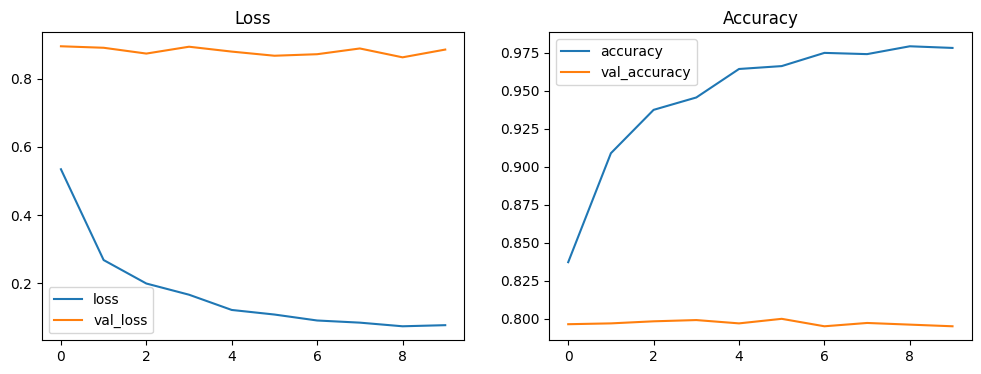

In [37]:
# Plot fine-tuning history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_fine.history['loss'], label='loss')
plt.plot(history_fine.history['val_loss'], label='val_loss')
plt.legend()
plt.title('Loss')

plt.subplot(1, 2, 2)
plt.plot(history_fine.history['accuracy'], label='accuracy')
plt.plot(history_fine.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.title('Accuracy')

plt.show()

## Model Quantization

### Convert the Model to TensorFlow Lite Format with Quantization

Reduce the model size and increase inference speed through post-training quantization.


In [ ]:
# Convert the model to TensorFlow Lite format with quantization
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quant_model = converter.convert()

# Save the quantized model
with open('model_quant.tflite', 'wb') as f:
    f.write(tflite_quant_model)


In this code block, we convert the trained model to TensorFlow Lite format with post-training quantization. This reduces the model size and increases inference speed, making it suitable for deployment on resource-constrained devices.


## Testing with Custom Images

### Upload and Preprocess Custom Image

Upload an image from your local device and preprocess it for prediction.


In [58]:
from google.colab import files
uploaded = files.upload()
image_data = next(iter(uploaded.values()))

from PIL import Image
import io

def preprocess_image(image_data):
    image = Image.open(io.BytesIO(image_data))
    image = image.resize((128, 128))
    image = np.array(image) / 255.0  # Normalize to [0, 1] range
    image = np.expand_dims(image, axis=0)  # Add batch dimension
    return image

# Preprocess the uploaded image
image = preprocess_image(image_data)

Saving Ragdoll Cat.jpg to Ragdoll Cat.jpg


In this code block, we upload a custom image using the `files.upload()` function from the `google.colab` package. The uploaded image is then preprocessed to match the input format expected by the model, including resizing and normalization.


### Make Predictions and Display the Labeled Class

Make predictions using the model and display the predicted class with its corresponding label.


In [59]:
# Make predictions
predictions = model.predict(image)
predicted_class = np.argmax(predictions[0])
print(f'Predicted class: {class_names[predicted_class]}')

1/1 [==============================] - 0s 197ms/step
Predicted class: Ragdoll


### Available Pet Breeds in Oxford-IIIT Pet Dataset

To assist you in identifying the available pet breeds in the Oxford-IIIT Pet Dataset, here is a table listing all the breeds:

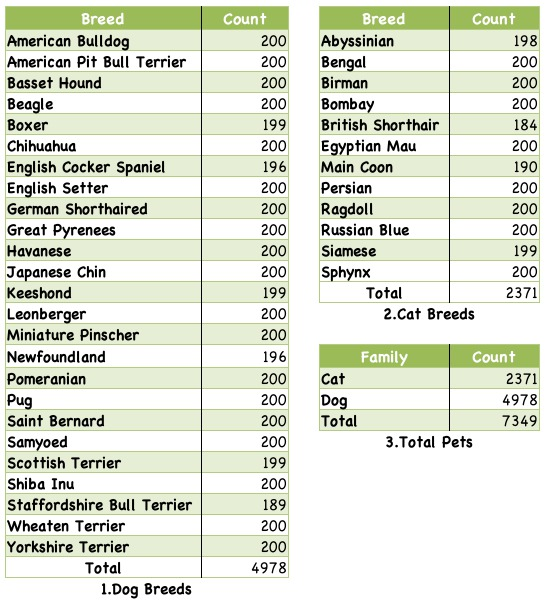